Nama Lengkap: Muhammad Sulthan Nasyira

Alur Belajar: Machine Learning Engineer

Cohort ID: MC589D5Y2486

Coding Camp Email Username: mc589d5y2486@student.devacademy.id

Email Terdaftar: sulthanasyirah@gmail.com

Group Belajar: MC-49

# 1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 2. Load Data

In [ ]:
df = pd.read_csv('bitcoin_2018_2025.csv')
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.rename(columns={'Open time': 'Date'})
df.set_index('Date', inplace=True)
df = df.sort_index()

# 3. Ambil data

In [ ]:
last_date = df.index[-1]
start_date = last_date - pd.DateOffset(years=5)
df = df[df.index >= start_date]


# 4. Visualisasi Data Historis

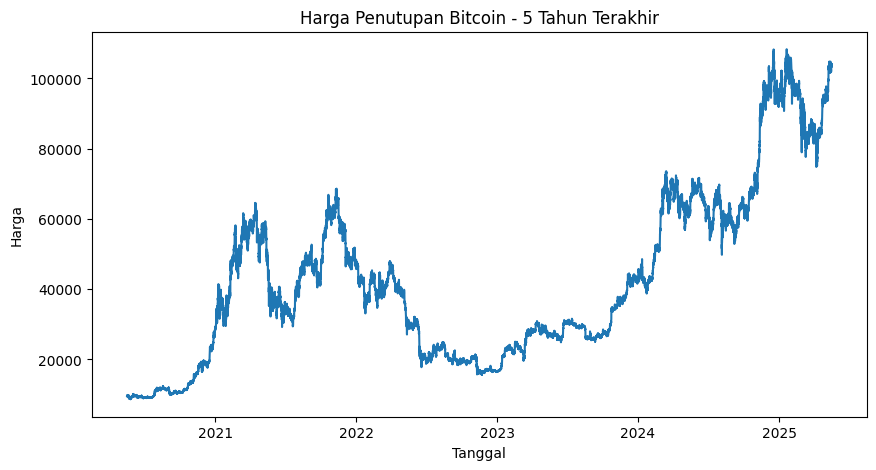

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.title('Harga Penutupan Bitcoin - 5 Tahun Terakhir')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.show()


# 5. Normalisasi

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# 6. Membuat Dataset untuk LSTM

In [ ]:
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 1800
X, y = create_dataset(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 7. Split Data

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 8. Membangun dan Melatih Model

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

print("Training model...")
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model...
Epoch 1/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 98s 90ms/step - loss: 0.0025
Epoch 2/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 140s 89ms/step - loss: 4.1242e-05
Epoch 3/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - loss: 3.4935e-05
Epoch 4/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 94s 89ms/step - loss: 3.3889e-05
Epoch 5/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - loss: 2.5788e-05
Epoch 6/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - loss: 2.2569e-05
Epoch 7/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 141s 88ms/step - loss: 2.0711e-05
Epoch 8/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - loss: 1.5381e-05
Epoch 9/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 141s 89ms/step - loss: 1.2745e-05
Epoch 10/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - loss: 1.5828e-05


263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step


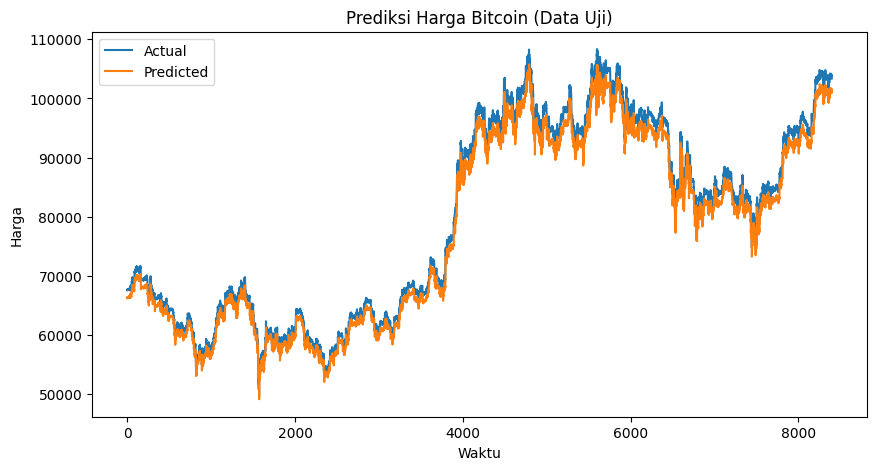

MSE : 3325259.55
MAE : 1695.01
R² Score : 0.9874


In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Prediksi Harga Bitcoin (Data Uji)')
plt.xlabel('Waktu')
plt.ylabel('Harga')
plt.legend()
plt.show()

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'MSE : {mse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'R² Score : {r2:.4f}')

# 9. Prediksi

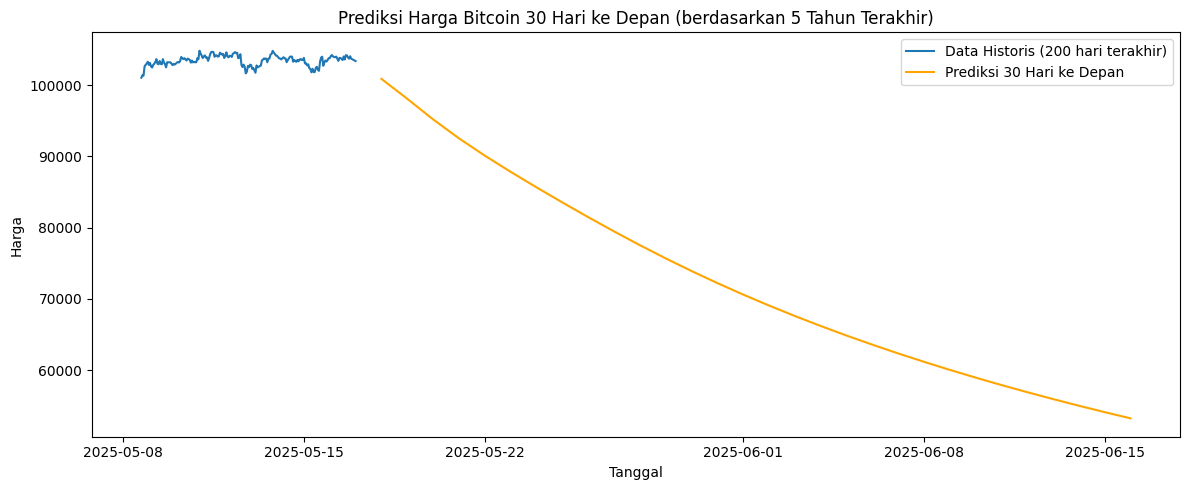

In [ ]:
last_60_days = scaled_data[-window_size:]
input_seq = last_60_days.reshape(1, window_size, 1)

future_predictions = []
for _ in range(30):
    next_pred = model.predict(input_seq, verbose=0)[0, 0]
    future_predictions.append(next_pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12, 5))
plt.plot(df.index[-200:], df['Close'].values[-200:], label='Data Historis (200 hari terakhir)')
plt.plot(future_dates, future_predictions_inv, label='Prediksi 30 Hari ke Depan', color='orange')
plt.title('Prediksi Harga Bitcoin 30 Hari ke Depan (berdasarkan 5 Tahun Terakhir)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.tight_layout()
plt.show()